In [1]:
import lrr_prototype as lrr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
base_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought'
data_dir = f'{base_dir}/data'
reservoir_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/DROM_CONUS_Analysis/Data/HydroShare'
output_dir = f'{data_dir}/results/lrr_output'

os.chdir(base_dir)

In [4]:
# ---- Prepare the model run for a specific basin ---- #

huc4 = '1709'

# constant parameters
grid_length = 111 / 8    # grid length (km)

# simulation period
start_date = '1988-01-01'
end_date = '2019-12-31'

# define run directory
run_dir = f'/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/results/lrr_output/{huc4}'
if not os.path.exists(run_dir):
    os.makedirs(run_dir)

# reservoir storage file path - for assimilation
reservoir_storage_file_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/reservoir_storage.csv'

# read conus grid nc
conus_grid_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/conus_nldas_grid.nc'
lat_array_conus, lon_array_conus, grid_id_array_conus, flow_dir_array_conus = lrr.read_conus_grid_nc(conus_grid_nc_path)

# read conus reservoir nc
conus_res_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/reservoirs.nc'
res_gid_array, res_grid_id_array, res_max_storage_array, res_lat_array, res_lon_array = lrr.read_conus_reservoir_nc(conus_res_nc_path)

# read huc4 basin
nhd_data_dir = '/Users/donghui/Box Sync/Research/PhD/Projects/Drought_Cycle_Analysis/Data'
gdf_huc2_conus, gdf_huc4_conus, gdf_huc4 = lrr.read_huc4_basin(huc4, nhd_data_dir)

# get grids in huc4
gdf_huc4_points, lon_index_array, lat_index_array = lrr.get_grids_in_hu(lon_array_conus, lat_array_conus, gdf_huc4)

# sort grids by flow direction
upstream_grid_dict, upstream_grid_id_dict, G, flow_dir_array_huc4 = lrr.sort_grids_by_flow_dir(flow_dir_array_conus, gdf_huc4_points, grid_id_array_conus, lat_array_conus, lon_array_conus)

# read nldas runoff
nldas_runoff_nc_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/nldas_runoff.nc'
nldas_qs_array, nldas_qsb_array = lrr.read_nldas_runoff(nldas_runoff_nc_path, lat_index_array, lon_index_array, start_date, end_date)    # [time, lat, lon]

# read gcam water demand
gcam_demand_file_path = '/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/total_consumption_conus.nc'
total_demand_array = lrr.read_gcam_demand(gcam_demand_file_path, lat_index_array, lon_index_array, start_date, end_date)

# read pdsi
pdsi_file_path = f'/Users/donghui/Box Sync/Research/PhD/Projects/Water_Supply_Drought/data/processed/LRR/input/pdsi_{huc4}.csv'
pdsi_array = lrr.read_pdsi(pdsi_file_path, start_date, end_date)

# prepare doy array
doy_array = pd.date_range(start_date, end_date).dayofyear.values

# save variables
# save_var_list = [
#     'grid_id', 'reservoir_id', 'reservoir_storage_start', 'reservoir_storage_end', 'outflow_before_operation', 'outflow_after_operation', 
#     'grid_storage_start', 'grid_storage_end', 'flow_direction']
save_var_list = []    # don't save any variables, just for analysis

In [4]:
# ---- Calculate model metric for each run ---- #

def calculate_run_metric(
        model_states: list,    # model states
        start_date: str,    # start date of the simulation
        end_date: str,    # end date of the simulation
        start_date_calibration: str,    # start date of the calibration period
        end_date_calibration: str,    # end date of the calibration period
    ):
    """
    Calculate model metric for each run.
        The metric is based on the reservoir release.
    
    Return:
        metric_list: [[reservoir_id, r2_release, pbias_release, nrmse_release], [...], ...]
        df_reservoir_ts: dataframe of reservoir time series
    """

    date_list = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()
    # check if the date list is the same as the model states
    if len(date_list) != len(model_states):
        raise ValueError('The length of the date list is not the same as the model states.')

    # Access the first model state to get grid attributes
    grid_id = model_states[0]['grid_id'][:, :].astype(int)
    flow_dir_grid = model_states[0]['flow_direction'][:, :].astype(int)
    reservoir_id_grid = model_states[0]['reservoir_id'][:, :].astype(int)

    reservoir_in_huc4_id = np.unique(reservoir_id_grid[(flow_dir_grid!=-1) & (reservoir_id_grid!=0)])    # get the reservoir id in the huc4 basin
    # Create dictionary to store reservoir time series
    reservoir_ts_dict = {'date': pd.to_datetime(date_list)}
    for reservoir_id in reservoir_in_huc4_id:
        reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'] = np.zeros(len(date_list))
        reservoir_ts_dict[f'reservoir_{reservoir_id}_release'] = np.zeros(len(date_list))

    # Loop through each model state
    for i, date in enumerate(date_list):
        ds = model_states[i]
        reservoir_storage_start_grid = ds['reservoir_storage_start'][:, :]
        reservoir_storage_end_grid = ds['reservoir_storage_end'][:, :]
        outflow_before_operation_grid = ds['outflow_before_operation'][:, :]
        outflow_after_operation_grid = ds['outflow_after_operation'][:, :]

        for reservoir_id in reservoir_in_huc4_id:
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'][i] = reservoir_storage_start_grid[reservoir_id_grid==reservoir_id]
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'][i] = reservoir_storage_end_grid[reservoir_id_grid==reservoir_id]

            grid_id_associated = grid_id[reservoir_id_grid==reservoir_id][0]    # get the grid id associated with the reservoir
            inflow = outflow_before_operation_grid[grid_id==grid_id_associated][0]    # get the inflow from the grid: outflow_before_operation
            release = outflow_after_operation_grid[grid_id==grid_id_associated][0]    # get the release from the grid: outflow_after_operation
            reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'][i] = inflow * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day
            reservoir_ts_dict[f'reservoir_{reservoir_id}_release'][i] = release * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day

    # Convert dictionary to dataframe
    df_reservoir_ts = pd.DataFrame(reservoir_ts_dict)
    df_reservoir_ts.set_index('date', inplace=True)

    # Read reservoir metadata
    df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

    # Calculate metrics & store
    metric_list = []    # [[reservoir_id, r2_release, pbias_release, nrmse_release], [...], ...]
    # Read observed release & add to df_reservoir_ts
    for reservoir_id in reservoir_in_huc4_id:
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_release'] = np.nan
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_storage_start'] = np.nan
        df_reservoir_ts[f'reservoir_{reservoir_id}_observed_inflow'] = np.nan

        reservoir_smax = df_res_meta.loc[df_res_meta['ID']==reservoir_id, 'Maximum Storage'].values[0]
        df_ts = pd.read_csv(f'{reservoir_data_dir}/data_training/{reservoir_id}.csv')
        df_ts[['Storage', 'NetInflow', 'Release']] = df_ts[['Storage', 'NetInflow', 'Release']] * reservoir_smax
        df_ts['Time'] = pd.to_datetime(df_ts['Time'])
        df_ts.set_index('Time', inplace=True)
        # if df_ts has duplicate index, drop the duplicate. This can happen when observations have the same date mistakenly.
        if df_ts.index.duplicated().any():
            df_ts = df_ts[~df_ts.index.duplicated(keep='first')]

        # add observed release to df_reservoir_ts
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_release'] = df_ts['Release']
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_storage_start'] = df_ts['Storage']
        df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_inflow'] = df_ts['NetInflow']

        # Calculate metrics
        # # drop nan
        # df_reservoir_ts_dropna = df_reservoir_ts.dropna()

        # # access the calibration period
        # df_reservoir_ts_dropna = df_reservoir_ts_dropna.loc[start_date_calibration:end_date_calibration]
        #### above error: cannot dropna for all existing columns

        # drop nan for release of reservoir_id
        df_reservoir_ts_dropna = df_reservoir_ts[[f'reservoir_{reservoir_id}_observed_release', f'reservoir_{reservoir_id}_release']].dropna()
        # access the calibration period
        df_reservoir_ts_dropna = df_reservoir_ts_dropna.loc[start_date_calibration:end_date_calibration]

        # 1. r2 score
        r2_release = r2_score(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'])

        # 2. percent bias
        pbias_release = (df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'].sum() - df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum()) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum() * 100

        # 3. nRMSE
        nrmse_release = mean_squared_error(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'], squared=False) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].mean()
        
        # add to metric list
        metric_list.append([reservoir_id, r2_release, pbias_release, nrmse_release])

    return metric_list, df_reservoir_ts

# Test
# start_date = '1990-10-01'
# end_date = '1992-10-01'
# start_date_calibration = '1991-01-01'
# end_date_calibration = '1992-10-01'
# # initialize grid
# nrows, ncols = flow_dir_array_huc4.shape
# grid_id_array_huc4 = grid_id_array_conus[np.ix_(lat_index_array, lon_index_array)]
# grid = lrr.initialize_grid(nrows, ncols, res_grid_id_array, res_gid_array, res_max_storage_array, grid_id_array_huc4, grid_length, flow_dir_array_huc4)
# model_states = lrr.run_simulation(run_dir, grid_length, upstream_grid_dict, grid, start_date, end_date, nldas_qs_array, nldas_qsb_array, pdsi_array, doy_array, save_var_list, u_e)
# metric_list, df_reservoir_ts = calculate_run_metric(model_states, start_date, end_date, start_date_calibration, end_date_calibration)


In [5]:
# ---- Run the model for each grid in the basin ---- #
# ---- Modify the parameters here ---- #

# define if the demand is considered
# usually, the demand is not considered for the calibration, and is considered for the simulation
is_demand = True

# define range of u_e to test
u_e_array = np.arange(0.01, 0.16, 0.01)

# define the calibration period
start_date_calibration = (pd.to_datetime(start_date) + pd.DateOffset(years=3)).strftime('%Y-%m-%d')    # start date of the calibration period (3 years after the start date), the first 2 years are used for warm up
end_date_calibration = end_date

# initiliaze metric dictionary for all runs
metric_list_all_runs = []    # [[metric_list_run_1], [metric_list_run_2], ...]
df_reservoir_ts_all_runs = []    # [df_reservoir_ts_run_1, df_reservoir_ts_run_2, ...]

# run the model for each u_e
for (i, u_e) in enumerate(u_e_array):
    print(f'{i}: Running u_e = {u_e} ...')

    # initialize grid
    nrows, ncols = flow_dir_array_huc4.shape
    grid_id_array_huc4 = grid_id_array_conus[np.ix_(lat_index_array, lon_index_array)]
    grid = lrr.initialize_grid(nrows, ncols, res_grid_id_array, res_gid_array, res_max_storage_array, grid_id_array_huc4, grid_length, flow_dir_array_huc4)

    # run simulation
    model_states = lrr.run_simulation(run_dir, reservoir_storage_file_path, grid_length, upstream_grid_dict, grid, start_date, end_date, nldas_qs_array, nldas_qsb_array, total_demand_array, pdsi_array, doy_array, save_var_list, u_e, is_demand)

    # post-process model states
    metric_list, df_reservoir_ts = calculate_run_metric(model_states, start_date, end_date, start_date_calibration, end_date_calibration)
    metric_list_all_runs.append(metric_list)
    df_reservoir_ts_all_runs.append(df_reservoir_ts)


0: Running u_e = 0.01 ...
1: Running u_e = 0.02 ...
2: Running u_e = 0.03 ...
3: Running u_e = 0.04 ...
4: Running u_e = 0.05 ...
5: Running u_e = 0.06 ...
6: Running u_e = 0.07 ...
7: Running u_e = 0.08 ...
8: Running u_e = 0.09 ...
9: Running u_e = 0.1 ...
10: Running u_e = 0.11 ...
11: Running u_e = 0.12 ...
12: Running u_e = 0.13 ...
13: Running u_e = 0.14 ...
14: Running u_e = 0.15 ...


# Select Best u_e

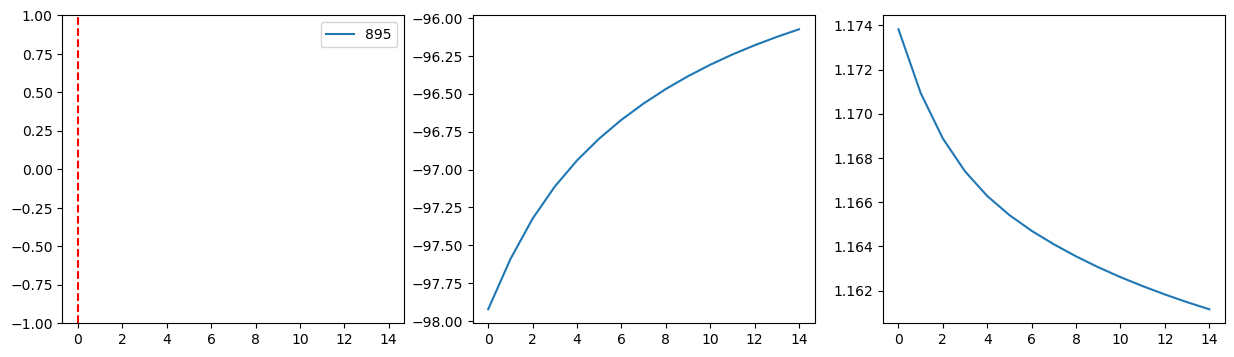

In [6]:
# ---- Plot metrics for all reservoirs for all runs ---- #

ind_line = 0

# create a dictionary to store NSE for each reservoir: {reservoir_id: [NSE_run_1, NSE_run_2, ...]}
nse_dict = {res_metric[0]: [] for res_metric in metric_list}
pbias_dict = {res_metric[0]: [] for res_metric in metric_list}
nrmse_dict = {res_metric[0]: [] for res_metric in metric_list}

# loop through each run
for i, metric_list in enumerate(metric_list_all_runs):
    # loop through each reservoir
    for res_metric in metric_list:
        reservoir_id = res_metric[0]
        nse = res_metric[1]
        nse_dict[reservoir_id].append(nse)
        pbias = res_metric[2]
        pbias_dict[reservoir_id].append(pbias)
        nrmse = res_metric[3]
        nrmse_dict[reservoir_id].append(nrmse)

# plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for reservoir_id, nse_list in nse_dict.items():
    ax[0].plot(range(len(u_e_array)), nse_list, label=reservoir_id)
    ax[0].set_ylim([-1, 1])
    # add a vertical line
    ax[0].axvline(x=ind_line, color='red', linestyle='--')
    ax[1].plot(range(len(u_e_array)), pbias_dict[reservoir_id], label=reservoir_id)
    ax[2].plot(range(len(u_e_array)), nrmse_dict[reservoir_id], label=reservoir_id)
    ax[0].legend() 
# ax.set_xlabel('u_e')
# ax.set_ylabel('NSE')
# ax.set_title(f'NSE for each reservoir for different u_e')
plt.show()

## Plot to help select best $u_e$

In [7]:
# ---- Plot reservoir release simulation for the best run ---- #

# # select the index of the best run
# u_e_best_index = 4

u_e_best_test_list = range(0, 15)

for u_e_best_index in u_e_best_test_list:
    # get the full simulation of the best run
    df_reservoir_ts_best = df_reservoir_ts_all_runs[u_e_best_index]

    # plot simulated release vs. observed release for each reservoir
    reservoir_id_list = list(set(df_reservoir_ts_best.columns[df_reservoir_ts_best.columns.str.contains('_release')].str.split('_').str[1].tolist()))
    for reservoir_id in reservoir_id_list:
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_observed_release'], label='observed')
        ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_release'], label='simulated')
        ax.set_title(f'Reservoir {reservoir_id}')
        ax.legend()

        if not os.path.exists(f'{run_dir}/calibration_plots/release'):
            os.makedirs(f'{run_dir}/calibration_plots/release')

        plt.savefig(f'{run_dir}/calibration_plots/release/reservoir_{reservoir_id}_daily_release_ue={u_e_array[u_e_best_index]:.2f}.jpg', dpi=150)
        plt.close()

        # plot in monthly scale
        fig, ax = plt.subplots(figsize=(15, 4))
        df_reservoir_ts_best[f'reservoir_{reservoir_id}_observed_release'].resample('M').mean().plot(label='observed')
        df_reservoir_ts_best[f'reservoir_{reservoir_id}_release'].resample('M').mean().plot(label='simulated')
        ax.set_title(f'Reservoir {reservoir_id}')
        ax.legend()

        # if calibration_plots/release folder does not exist, create it
        plt.savefig(f'{run_dir}/calibration_plots/release/reservoir_{reservoir_id}_monthly_release_ue={u_e_array[u_e_best_index]:.2f}.jpg', dpi=150)
        plt.close() 



# Rerun With Best u_e

In [8]:
# ---- Rerun for the best u_e ---- #
# ---- Save model states ---- #

# best u_e
u_e_best_index = 4
u_e = u_e_array[u_e_best_index]

# define the calibration period
start_date_calibration = (pd.to_datetime(start_date) + pd.DateOffset(years=3)).strftime('%Y-%m-%d')    # start date of the calibration period (3 years after the start date), the first 2 years are used for warm up
end_date_calibration = end_date

# initiliaze metric dictionary for all runs
metric_list_all_runs = []    # [[metric_list_run_1], [metric_list_run_2], ...]
df_reservoir_ts_all_runs = []    # [df_reservoir_ts_run_1, df_reservoir_ts_run_2, ...]

# run the model for each u_e
print(f'{i}: Running u_e = {u_e} ...')

# initialize grid
nrows, ncols = flow_dir_array_huc4.shape
grid_id_array_huc4 = grid_id_array_conus[np.ix_(lat_index_array, lon_index_array)]
grid = lrr.initialize_grid(nrows, ncols, res_grid_id_array, res_gid_array, res_max_storage_array, grid_id_array_huc4, grid_length, flow_dir_array_huc4)

# run simulation
model_states = lrr.run_simulation(run_dir, reservoir_storage_file_path, grid_length, upstream_grid_dict, grid, start_date, end_date, nldas_qs_array, nldas_qsb_array, total_demand_array, pdsi_array, doy_array, save_var_list, u_e, is_demand)

# post-process model states
metric_list, df_reservoir_ts = calculate_run_metric(model_states, start_date, end_date, start_date_calibration, end_date_calibration)
metric_list_all_runs.append(metric_list)
df_reservoir_ts_all_runs.append(df_reservoir_ts)


14: Running u_e = 0.05 ...


In [9]:
# ---- Save model states ---- #

save_var_list_nontime = ['grid_id', 'reservoir_id', 'flow_direction']
save_var_list_time = [
    'reservoir_storage_start', 'reservoir_storage_end', 'outflow_before_operation', 'outflow_after_operation', 
    'grid_storage_start', 'grid_storage_end', 'total_water_demand', 'water_deficit'
]

# save model states to nc using netcdf4
nc_save_path = f'{run_dir}/model_states_{huc4}.nc'
timestamp = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()
with nc.Dataset(nc_save_path, 'w') as ds:
    # dimensions
    ds.createDimension('time', len(timestamp))
    ds.createDimension('lat', nrows)
    ds.createDimension('lon', ncols)

    # variables
    # non-time variables
    ds.createVariable('time', 'str', ('time',))
    ds.createVariable('lat', 'float32', ('lat',))
    ds.createVariable('lon', 'float32', ('lon',))
    ds.createVariable('grid_id', 'int', ('lat', 'lon',))
    ds.createVariable('reservoir_id', 'int', ('lat', 'lon',))
    ds.createVariable('flow_direction', 'int', ('lat', 'lon',))
    # time variables
    for var in save_var_list_time:
        ds.createVariable(var, 'float32', ('time', 'lat', 'lon',))

    # save variables
    # non-time variables
    ds['time'][:] = np.array(timestamp)
    ds['lat'][:] = lat_array_conus[lat_index_array]
    ds['lon'][:] = lon_array_conus[lon_index_array]
    ds['grid_id'][:] = grid_id_array_huc4
    ds['reservoir_id'][:] = grid['reservoir_id']
    ds['flow_direction'][:] = grid['flow_direction']
    # time variables
    for var in save_var_list_time:
        ds[var][:] = np.array([model_states[i][var][:, :] for i in range(len(model_states))])



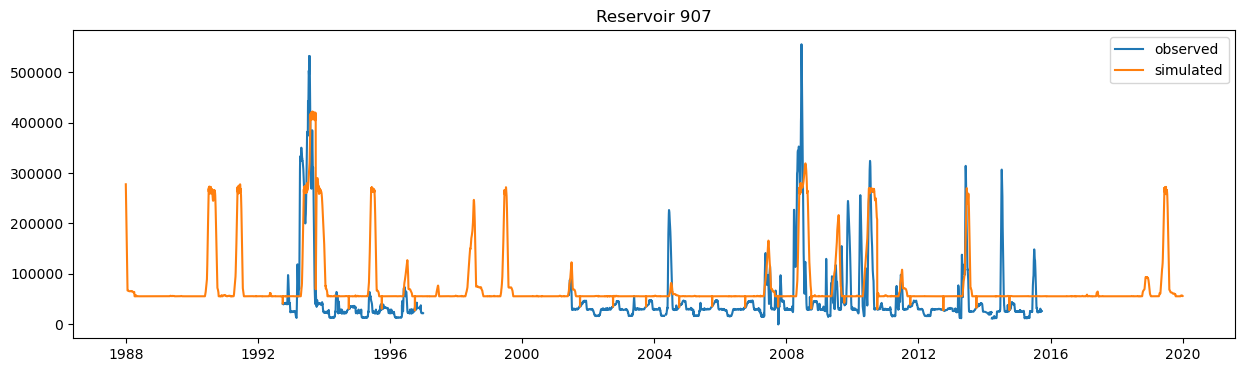

In [10]:
# ---- Plot reservoir storage simulation for the best run ---- #
# ---- using u_e from above ---- #


# get the full simulation of the best run
df_reservoir_ts_best = df_reservoir_ts_all_runs[0]    # default using 0 if best u_e has been rerun
u_e_best = u_e    # using the best u_e from above

# plot simulated release vs. observed release for each reservoir
reservoir_id_list = list(set(df_reservoir_ts_best.columns[df_reservoir_ts_best.columns.str.contains('_release')].str.split('_').str[1].tolist()))
for reservoir_id in reservoir_id_list:
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_observed_storage_start'], label='observed')
    ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_storage_start'], label='simulated')
    ax.set_title(f'Reservoir {reservoir_id}')
    ax.legend()

    if not os.path.exists(f'{run_dir}/calibration_plots/storage'):
        os.makedirs(f'{run_dir}/calibration_plots/storage')
    # plt.savefig(f'{run_dir}/calibration_plots/storage/reservoir_{reservoir_id}_daily_storage_start_ue={u_e_array[u_e_best_index]:.2f}.jpg', dpi=150)
    plt.savefig(f'{run_dir}/calibration_plots/storage/reservoir_{reservoir_id}_daily_storage_start_ue={u_e:.2f}.jpg', dpi=150)
    plt.show()

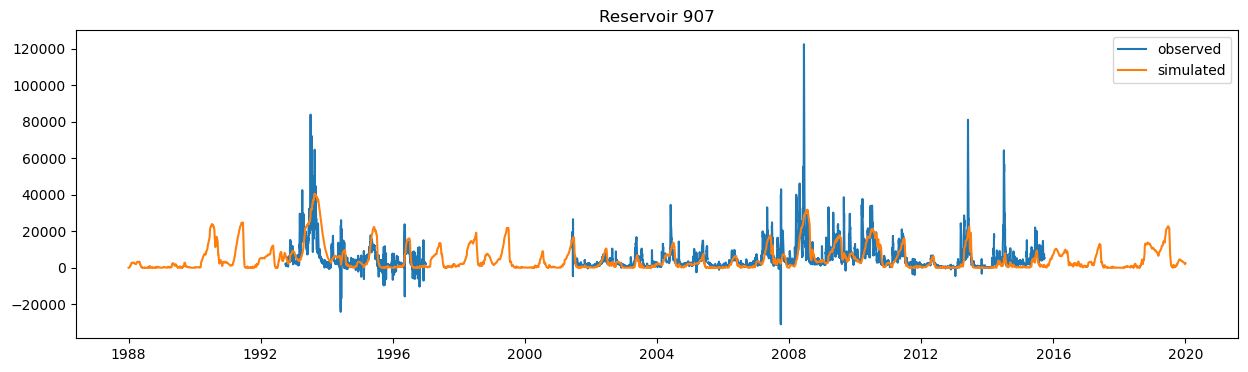

In [11]:
# ---- Plot reservoir inflow simulation for the best run ---- #

# get the full simulation of the best run
df_reservoir_ts_best = df_reservoir_ts_all_runs[0]

# plot simulated release vs. observed release for each reservoir
reservoir_id_list = list(set(df_reservoir_ts_best.columns[df_reservoir_ts_best.columns.str.contains('_release')].str.split('_').str[1].tolist()))
for reservoir_id in reservoir_id_list:
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_observed_inflow'], label='observed')
    ax.plot(df_reservoir_ts_best[f'reservoir_{reservoir_id}_inflow'], label='simulated')
    ax.set_title(f'Reservoir {reservoir_id}')
    ax.legend()

    if not os.path.exists(f'{run_dir}/calibration_plots/inflow'):
        os.makedirs(f'{run_dir}/calibration_plots/inflow')
    # plt.savefig(f'{run_dir}/calibration_plots/inflow/reservoir_{reservoir_id}_daily_inflow_ue={u_e_array[u_e_best_index]:.2f}.jpg', dpi=150)
    plt.savefig(f'{run_dir}/calibration_plots/inflow/reservoir_{reservoir_id}_daily_inflow_ue={u_e:.2f}.jpg', dpi=150)
    plt.show()

 



In [ ]:

huc4 = '0601'
# start_date = '1998-10-01'
# end_date = '2018-10-01'
start_date = '1980-10-01'
end_date = '2000-10-01'
date_list = pd.date_range(start_date, end_date, freq='D').strftime("%Y-%m-%d").tolist()

# Read the 1st .nc output file to get grid attributes
nc_file_path = f'{output_dir}/{huc4}_model_state_{date_list[0]}.nc'
with nc.Dataset(nc_file_path) as ds:
    grid_id = ds.variables['grid_id'][:, :].astype(int)
    flow_dir_grid = ds.variables['flow_direction'][:, :].astype(int)
    reservoir_id_grid = ds.variables['reservoir_id'][:, :].astype(int)

reservoir_in_huc4_id = np.unique(reservoir_id_grid[(flow_dir_grid!=-1) & (reservoir_id_grid!=0)])    # get the reservoir id in the huc4 basin
# Create dictionary to store reservoir time series
reservoir_ts_dict = {'date': pd.to_datetime(date_list)}
for reservoir_id in reservoir_in_huc4_id:
    reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'] = np.zeros(len(date_list))
    reservoir_ts_dict[f'reservoir_{reservoir_id}_release'] = np.zeros(len(date_list))

# Read .nc output file
for i, date in enumerate(date_list):
    nc_file_path = f'{output_dir}/{huc4}_model_state_{date}.nc'
    with nc.Dataset(nc_file_path) as ds:
        reservoir_storage_start_grid = ds.variables['reservoir_storage_start'][:, :]
        reservoir_storage_end_grid = ds.variables['reservoir_storage_end'][:, :]
        outflow_before_operation_grid = ds.variables['outflow_before_operation'][:, :]
        outflow_after_operation_grid = ds.variables['outflow_after_operation'][:, :]

        for reservoir_id in reservoir_in_huc4_id:
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_start'][i] = reservoir_storage_start_grid[reservoir_id_grid==reservoir_id]
            reservoir_ts_dict[f'reservoir_{reservoir_id}_storage_end'][i] = reservoir_storage_end_grid[reservoir_id_grid==reservoir_id]

            grid_id_associated = grid_id[reservoir_id_grid==reservoir_id][0]    # get the grid id associated with the reservoir
            inflow = outflow_before_operation_grid[grid_id==grid_id_associated][0]    # get the inflow from the grid: outflow_before_operation
            release = outflow_after_operation_grid[grid_id==grid_id_associated][0]    # get the release from the grid: outflow_after_operation
            reservoir_ts_dict[f'reservoir_{reservoir_id}_inflow'][i] = inflow * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day
            reservoir_ts_dict[f'reservoir_{reservoir_id}_release'][i] = release * 3600 * 24 * 0.000810714    # convert from m3/s to acft/day

# Convert dictionary to dataframe
df_reservoir_ts = pd.DataFrame(reservoir_ts_dict)
df_reservoir_ts.set_index('date', inplace=True)

In [ ]:
# ---- Check reservoir water balance: storage change = inflow - release ---- #

plot_start_date = start_date
plot_end_date = end_date
for reservoir_id in reservoir_in_huc4_id:
    df_reservoir_ts[f'reservoir_{reservoir_id}_storage_change_1'] = df_reservoir_ts[f'reservoir_{reservoir_id}_storage_end'] - df_reservoir_ts[f'reservoir_{reservoir_id}_storage_start']
    df_reservoir_ts[f'reservoir_{reservoir_id}_storage_change_2'] = df_reservoir_ts[f'reservoir_{reservoir_id}_inflow'] - df_reservoir_ts[f'reservoir_{reservoir_id}_release']

    fig, ax = plt.subplots()
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_storage_change_1'].plot(ax=ax, label='storage change 1')
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_storage_change_2'].plot(ax=ax, label='storage change 2')
    ax.legend()
    plt.show()

1763
r2 score of release: -0.7491698859699174
pbias of release: 27.36
nrmse of release: 1.048


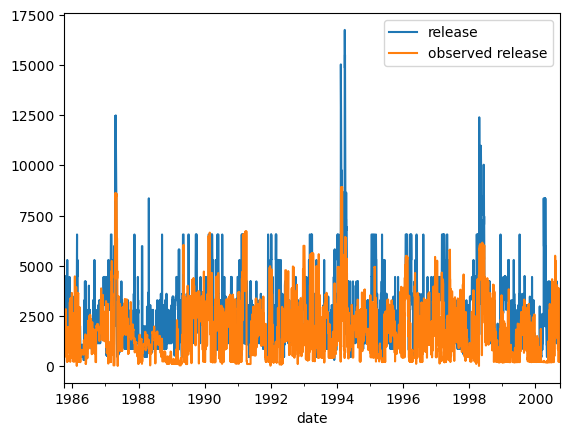

1765
r2 score of release: -1.848147056737047
pbias of release: 53.32
nrmse of release: 1.129


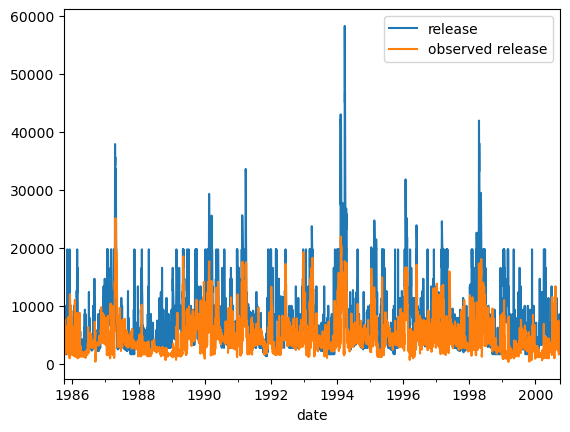

1767
r2 score of release: -1.335110693878668
pbias of release: 54.29
nrmse of release: 1.388


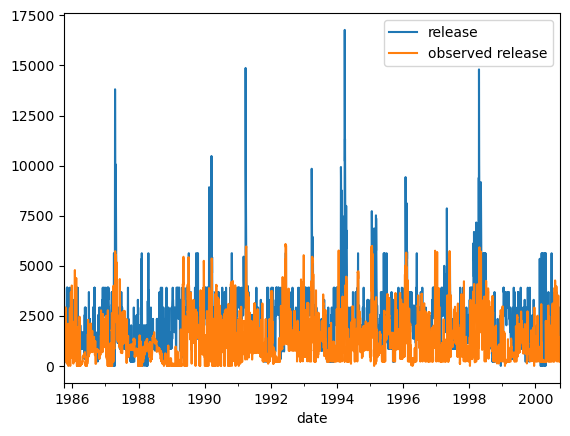

1770
r2 score of release: -1.1494800645654681
pbias of release: 48.33
nrmse of release: 1.207


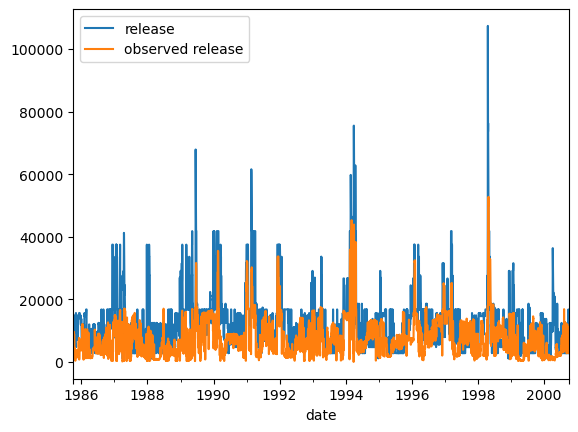

1774
r2 score of release: -2.1557417831434442
pbias of release: 57.38
nrmse of release: 1.470


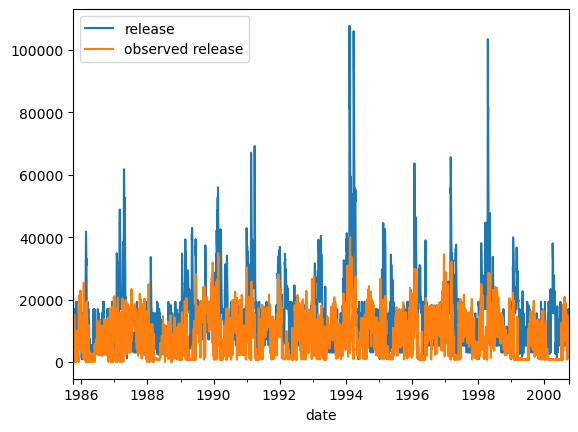

1781
r2 score of release: -3.821257954065816
pbias of release: 79.10
nrmse of release: 1.564


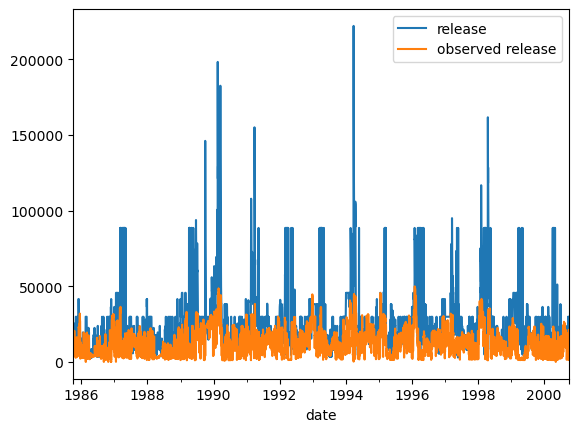

1783
r2 score of release: -0.8918553446911901
pbias of release: 49.74
nrmse of release: 1.143


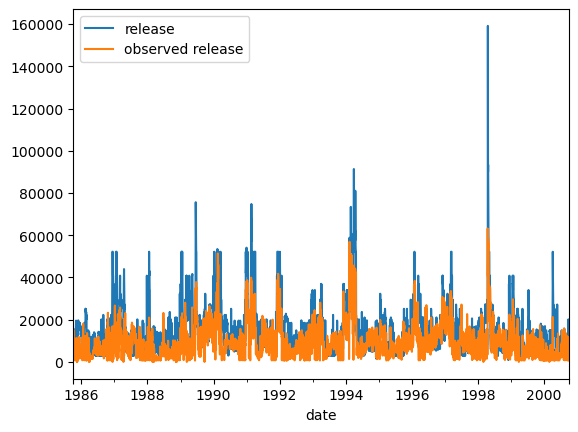

1801
r2 score of release: -4.020553285879962
pbias of release: 33.80
nrmse of release: 1.238


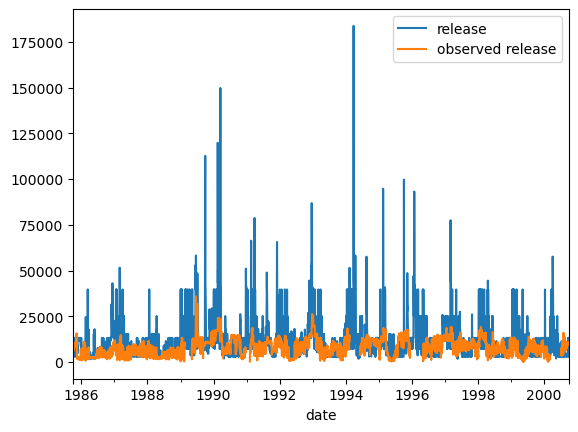

In [ ]:
# ---- Check reservoir release against the observed release ---- #

# plot_start_date = start_date
# plot_end_date = end_date
plot_start_date = '1985-10-01'
plot_end_date = '2000-10-01'
# plot_start_date = '2005-10-01'
# plot_end_date = '2018-10-01'

# reservoir metadata
df_res_meta = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

# Read observed release
for reservoir_id in reservoir_in_huc4_id:
    print(reservoir_id)

    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_release'] = np.nan
    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_storage_start'] = np.nan
    df_reservoir_ts[f'reservoir_{reservoir_id}_observed_inflow'] = np.nan

    reservoir_smax = df_res_meta.loc[df_res_meta['ID']==reservoir_id, 'Maximum Storage'].values[0]
    df_ts = pd.read_csv(f'{reservoir_data_dir}/data_training/{reservoir_id}.csv')
    df_ts[['Storage', 'NetInflow', 'Release']] = df_ts[['Storage', 'NetInflow', 'Release']] * reservoir_smax
    df_ts['Time'] = pd.to_datetime(df_ts['Time'])
    df_ts.set_index('Time', inplace=True)

    # add observed release to df_reservoir_ts
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_release'] = df_ts['Release']
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_storage_start'] = df_ts['Storage']
    df_reservoir_ts.loc[start_date:end_date, f'reservoir_{reservoir_id}_observed_inflow'] = df_ts['NetInflow']

    # Calculate metrics
    # drop nan
    df_reservoir_ts_dropna = df_reservoir_ts.dropna()
    # 1. r2 score
    r2_release = r2_score(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'])

    # 2. percent bias
    pbias_release = (df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'].sum() - df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum()) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].sum() * 100

    # 3. nRMSE
    nrmse_release = mean_squared_error(df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'], df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_release'], squared=False) / df_reservoir_ts_dropna[f'reservoir_{reservoir_id}_observed_release'].mean()
    
    print(f'r2 score of release: {r2_release}')
    print(f'pbias of release: {pbias_release:.2f}')
    print(f'nrmse of release: {nrmse_release:.3f}')
    # print(f'r2 score of inflow: {r2_inflow}')
    # print(f'r2 score of storage: {r2_storage}')

    fig, ax = plt.subplots()
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_release'].plot(ax=ax, label='release')
    df_reservoir_ts.loc[plot_start_date:plot_end_date, f'reservoir_{reservoir_id}_observed_release'].plot(ax=ax, label='observed release')
    ax.legend()
    plt.show()

In [ ]:
df_reservoir_ts.isna().sum()

reservoir_1151_storage_start                0
reservoir_1151_storage_end                  0
reservoir_1151_inflow                       0
reservoir_1151_release                      0
reservoir_1164_storage_start                0
                                         ... 
reservoir_1237_observed_storage_start       4
reservoir_1237_observed_inflow              4
reservoir_1287_observed_release          2923
reservoir_1287_observed_storage_start    2923
reservoir_1287_observed_inflow           2923
Length: 77, dtype: int64

In [ ]:
df_ts.index

DatetimeIndex(['1998-01-19', '1998-01-20', '1998-01-21', '1998-01-22',
               '1998-01-23', '1998-01-24', '1998-01-25', '1998-01-26',
               '1998-01-27', '1998-01-28',
               ...
               '2018-01-13', '2018-01-14', '2018-01-15', '2018-01-16',
               '2018-01-17', '2018-01-18', '2018-01-19', '2018-01-20',
               '2018-01-21', '2018-01-22'],
              dtype='datetime64[ns]', name='Time', length=7305, freq=None)

# Quick Plot for AGU

## Look at Basin Outlet

In [ ]:
# ---- save outlet flow to csv ---- #
outlet_grid_i, outlet_grid_j = list(upstream_grid_dict)[-1]    # get the outlet grid

# get outlet flow
outlet_flow_list = [model_state['outflow_after_operation'][outlet_grid_i, outlet_grid_j] for model_state in model_states]
# convert to acft/day
outlet_flow_list = np.array(outlet_flow_list) * 3600 * 24 * 0.000810714

# save to csv
df_outlet_flow = pd.DataFrame({'date': pd.date_range(start_date, end_date), 'outlet_flow': outlet_flow_list})
# df_outlet_flow.to_csv(f'{data_dir}/{huc4}_outlet_flow_without_res.csv', index=False)
# df_outlet_flow.to_csv(f'{data_dir}/{huc4}_outlet_flow_with_res.csv', index=False)
# df_outlet_flow.to_csv(f'{data_dir}/{huc4}_outlet_flow_with_res_without_route.csv', index=False)

In [ ]:
# ---- plot outlet flow ---- #
gauge_obs_df = pd.read_excel(f'{data_dir}/{huc4}_outlet_gage.xlsx')
gauge_obs_df['discharge_acft'] = gauge_obs_df['discharge'] * 3600 * 24 * 2.29569e-5    # convert from cfs to acft/day
gauge_obs_df['date'] = pd.to_datetime(gauge_obs_df['date'])

simflow_with_res_df = pd.read_csv(f'{data_dir}/{huc4}_outlet_flow_with_res.csv')
simflow_with_res_df['date'] = pd.to_datetime(simflow_with_res_df['date'])

simflow_without_res_df = pd.read_csv(f'{data_dir}/{huc4}_outlet_flow_without_res.csv')
simflow_without_res_df['date'] = pd.to_datetime(simflow_without_res_df['date'])

# plot outlet flow
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(gauge_obs_df['date'], gauge_obs_df['discharge_acft'], label='Observed')
ax.plot(simflow_with_res_df['date'], simflow_with_res_df['outlet_flow'], label='Simulated with reservoirs')
ax.plot(simflow_without_res_df['date'], simflow_without_res_df['outlet_flow'], label='Simulated without reservoirs')

ax.legend()

plt.show()


## Look at Release From Specific Reservoirs

In [ ]:
# ---- save release from specific reservoir ---- #

reservoir_id_list = list(set(df_reservoir_ts.columns[df_reservoir_ts.columns.str.contains('_release')].str.split('_').str[1].tolist()))
reservoir_id_list = [int(reservoir_id) for reservoir_id in reservoir_id_list]

res_release_dict = {gid: [] for gid in reservoir_id_list}
for gid in reservoir_id_list:
    grid_i, grid_j = np.where(grid['reservoir_id']==gid)
    grid_i = grid_i[0]
    grid_j = grid_j[0]

    # get reservoir release
    reservoir_release_list = [model_state['outflow_after_operation'][grid_i, grid_j] for model_state in model_states]
    # convert to acft/day
    reservoir_release_list = np.array(reservoir_release_list) * 3600 * 24 * 0.000810714

    res_release_dict[gid] = reservoir_release_list

# convert to dataframe
# add date
res_release_df = pd.DataFrame(res_release_dict)
res_release_df['date'] = pd.date_range(start_date, end_date)

# save to csv
# res_release_df.to_csv(f'{data_dir}/{huc4}_res_release_without_res.csv', index=False)
# res_release_df.to_csv(f'{data_dir}/{huc4}_res_release_with_res.csv', index=False)

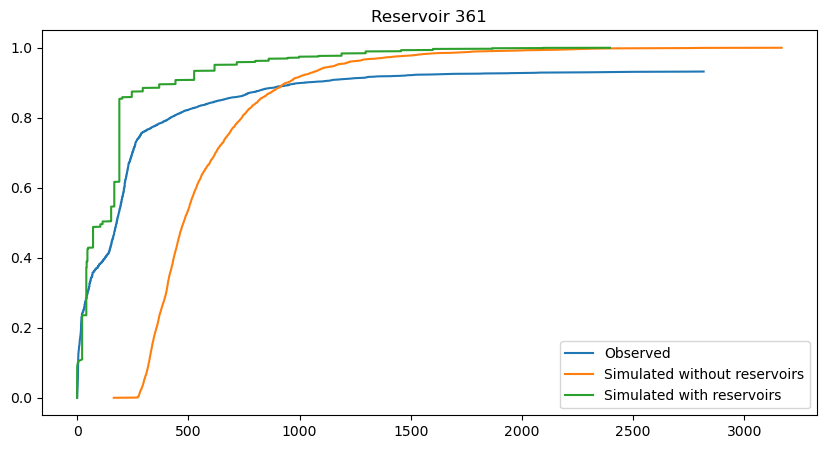

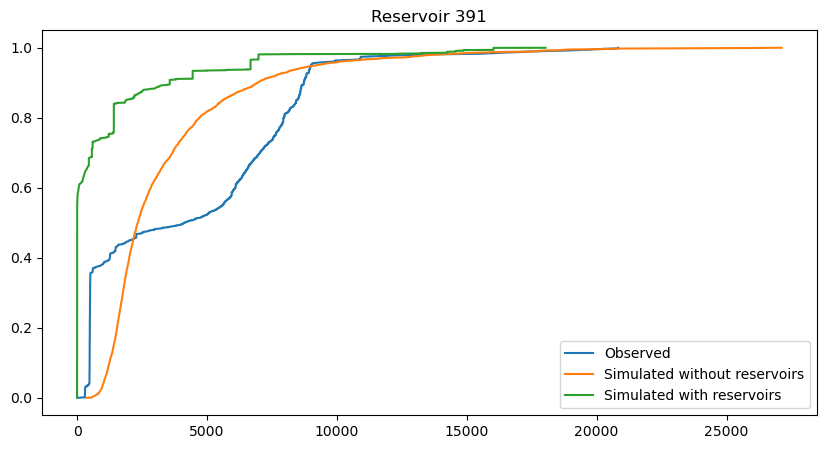

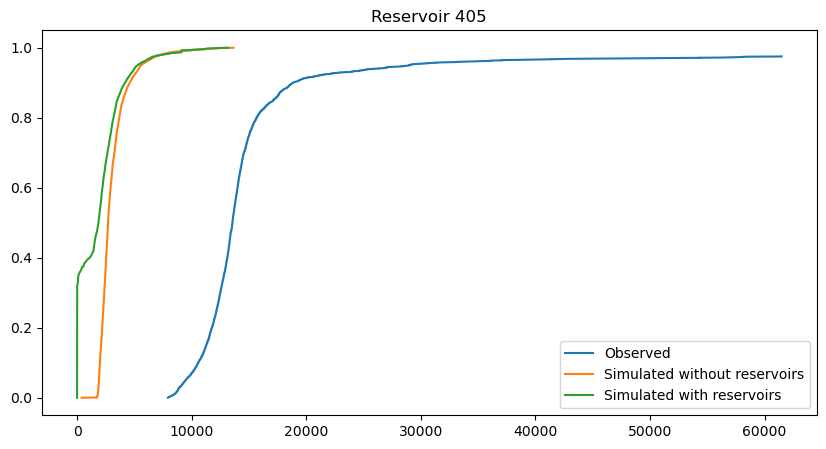

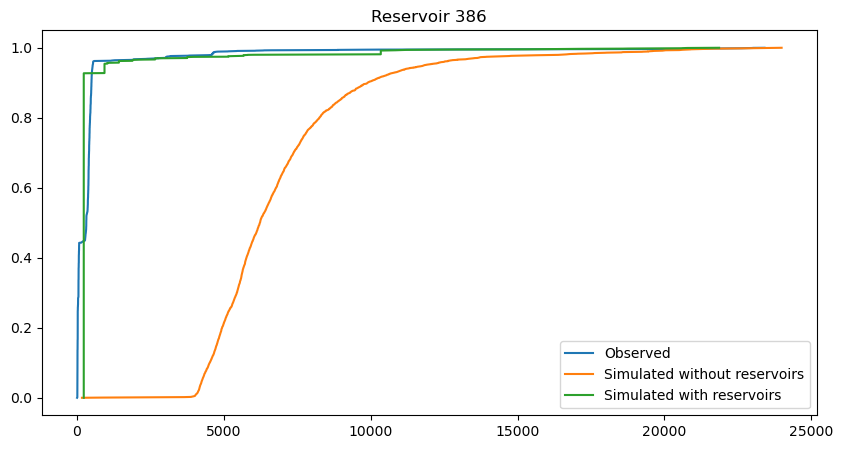

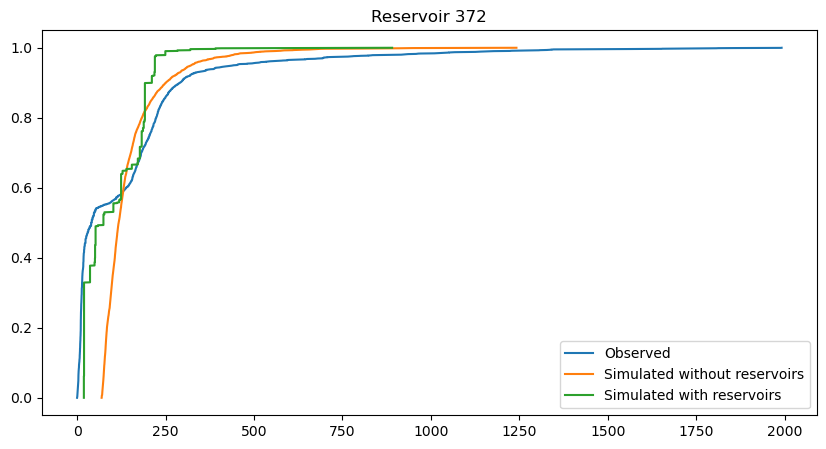

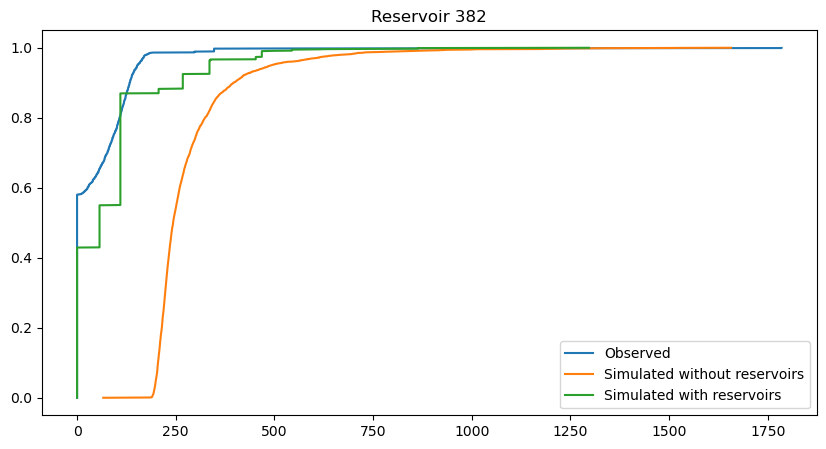

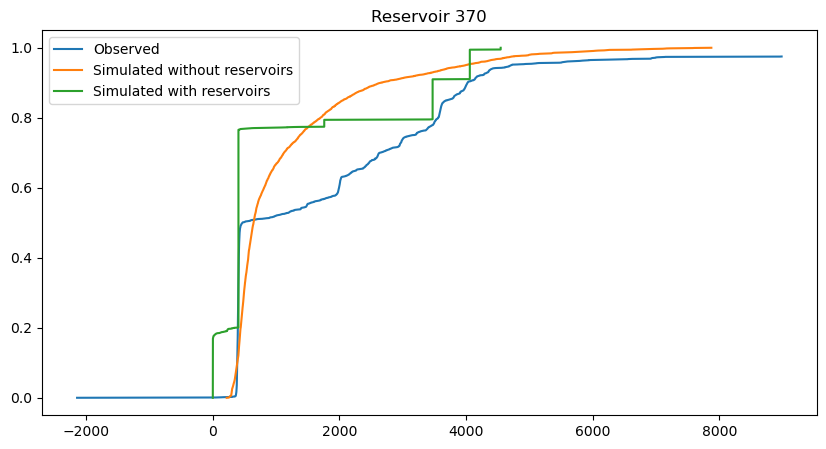

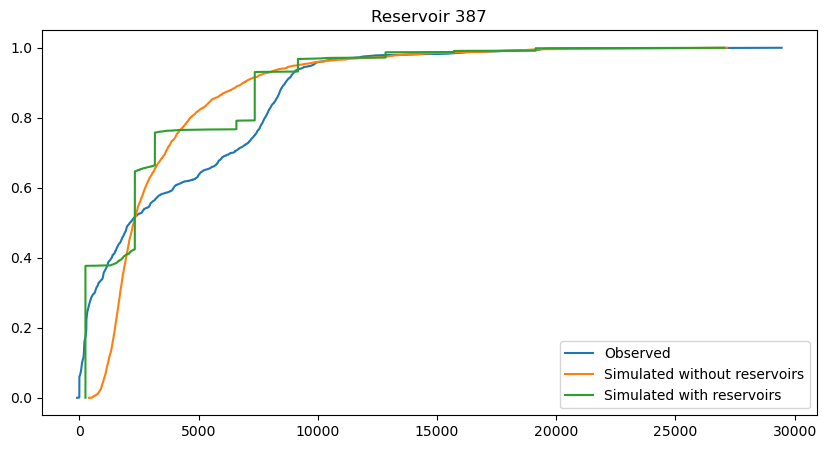

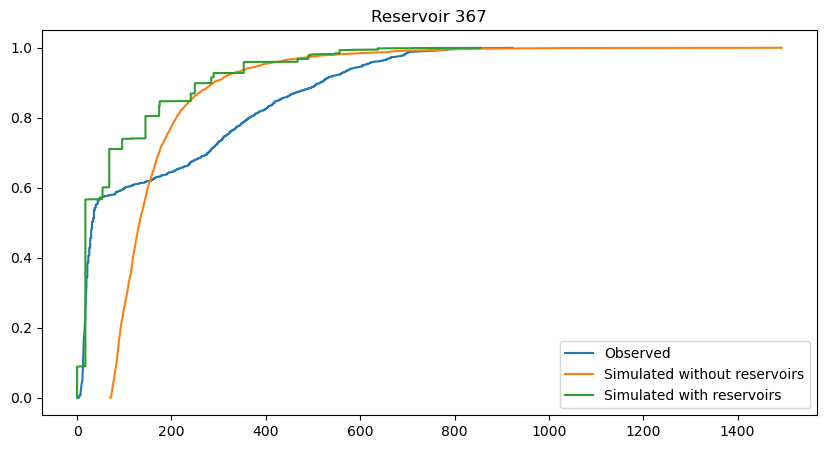

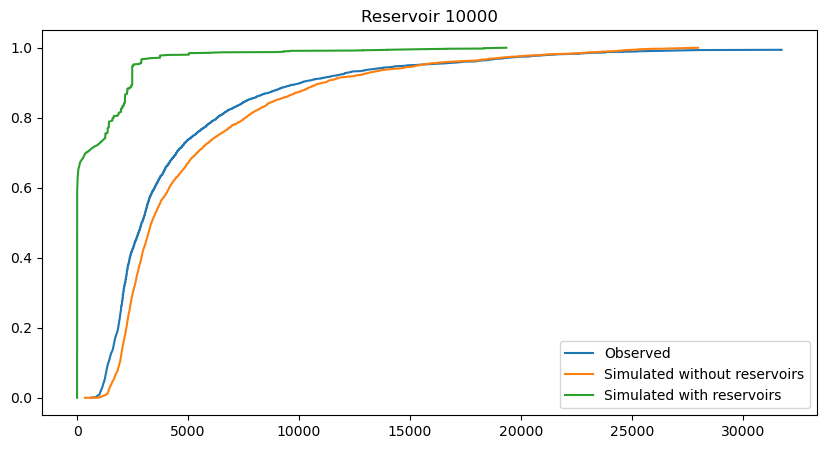

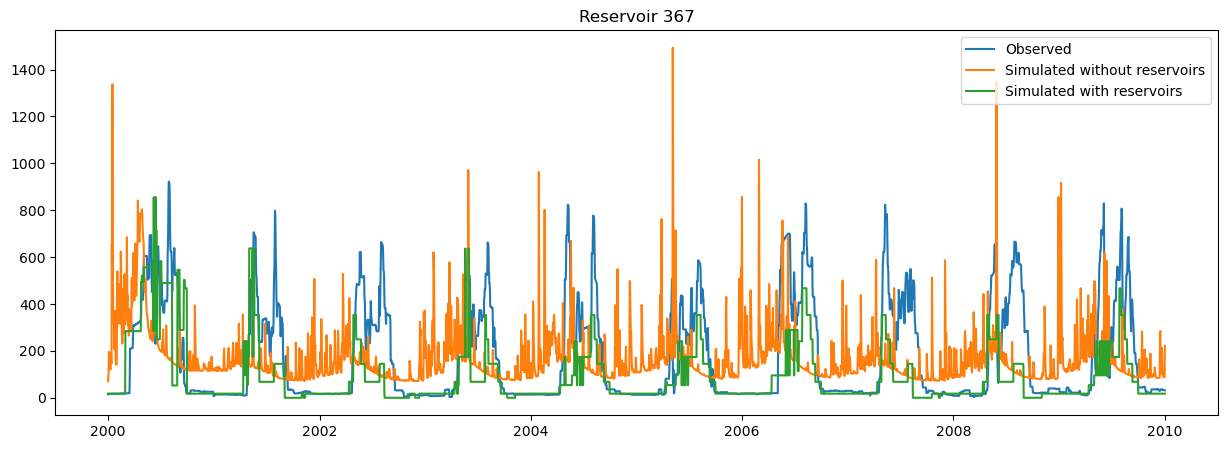

In [ ]:
# ---- plot cdf for each reservoir ---- #

release_with_res_df = pd.read_csv(f'{data_dir}/{huc4}_res_release_with_res.csv')
release_with_res_df['date'] = pd.to_datetime(release_with_res_df['date'])
release_with_res_df.set_index('date', inplace=True)
release_without_res_df = pd.read_csv(f'{data_dir}/{huc4}_res_release_without_res.csv')
release_without_res_df['date'] = pd.to_datetime(release_without_res_df['date'])
release_without_res_df.set_index('date', inplace=True)

reservoir_id_list = [int(reservoir_id) for reservoir_id in reservoir_id_list]

# plot ecdf
for gid in reservoir_id_list:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_reservoir_ts[f'reservoir_{gid}_observed_release'].sort_values(), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Observed')
    ax.plot(np.sort(release_without_res_df[f'{gid}']), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Simulated without reservoirs')
    ax.plot(np.sort(release_with_res_df[f'{gid}']), np.arange(1, len(release_with_res_df)+1) / len(release_with_res_df), label='Simulated with reservoirs')

    ax.set_title(f'Reservoir {gid}')
    ax.legend()
    plt.show()

# plot time series
for gid in reservoir_id_list:
    if gid != 367:
        continue
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df_reservoir_ts[f'reservoir_{gid}_observed_release'], label='Observed')
    ax.plot(release_without_res_df[f'{gid}'], label='Simulated without reservoirs')
    ax.plot(release_with_res_df[f'{gid}'], label='Simulated with reservoirs')

    ax.set_title(f'Reservoir {gid}')
    ax.legend()
    plt.show()

## Plot in One Place

In [6]:
import geopandas as gpd
from shapely.geometry import Point, LineString

# ---- Prepare flow line ---- #

########## Prepare flow lines ##########

huc2 = huc4[0:2]
crs = 'epsg:4326'
gdf_huc4 = gdf_huc4.copy()
gdf_huc4.set_crs(crs, inplace=True, allow_override=True)

if huc2 == '03':    # multiple NHDP files for 03
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['N','S','W']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['N','S','W']]
elif huc2 == '10': 
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDPlusAttributes' for i in ['U','L']]
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}{i}/NHDSnapshot/Hydrography' for i in ['U','L']]
else:
    flow_attr_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDPlusAttributes']
    hydro_file_list = [f'{nhd_data_dir}/Raw/NHDPlus/NHDPlus{huc2}/NHDSnapshot/Hydrography']

gdf_flow_list = []
for flow_attr_file, hydro_file in zip(flow_attr_file_list, hydro_file_list):
    gdf_fline_vaa = gpd.read_file(flow_attr_file, layer='PlusFlowlineVAA')
    gdf_fline = gpd.read_file(hydro_file, layer='NHDFlowline')

    # change COMID to ComID if the error exists
    if not 'ComID' in gdf_fline:
        gdf_fline.rename(columns={'COMID':'ComID'}, inplace=True)

    # change vaa file ComID to int
    to_int_var = ['ComID', 'StreamOrde', 'StreamCalc']
    gdf_fline_vaa[to_int_var] = gdf_fline_vaa[to_int_var].astype(int)

    # merge this two gdfs
    to_merge_vars = ['ComID', 'StreamOrde', 'StreamCalc', 'FromNode', 'ToNode']
    gdf_flow = gdf_fline.merge(gdf_fline_vaa[to_merge_vars], how='inner', on='ComID')
    
    gdf_flow_list.append(gdf_flow)

gdf_flow = pd.concat(gdf_flow_list)

# set crs
gdf_flow = gdf_flow.set_crs(crs, inplace=True, allow_override=True)

# subset to the target huc4
gdf_flow_huc4 = gdf_flow.sjoin(gdf_huc4, how='inner', predicate='intersects')


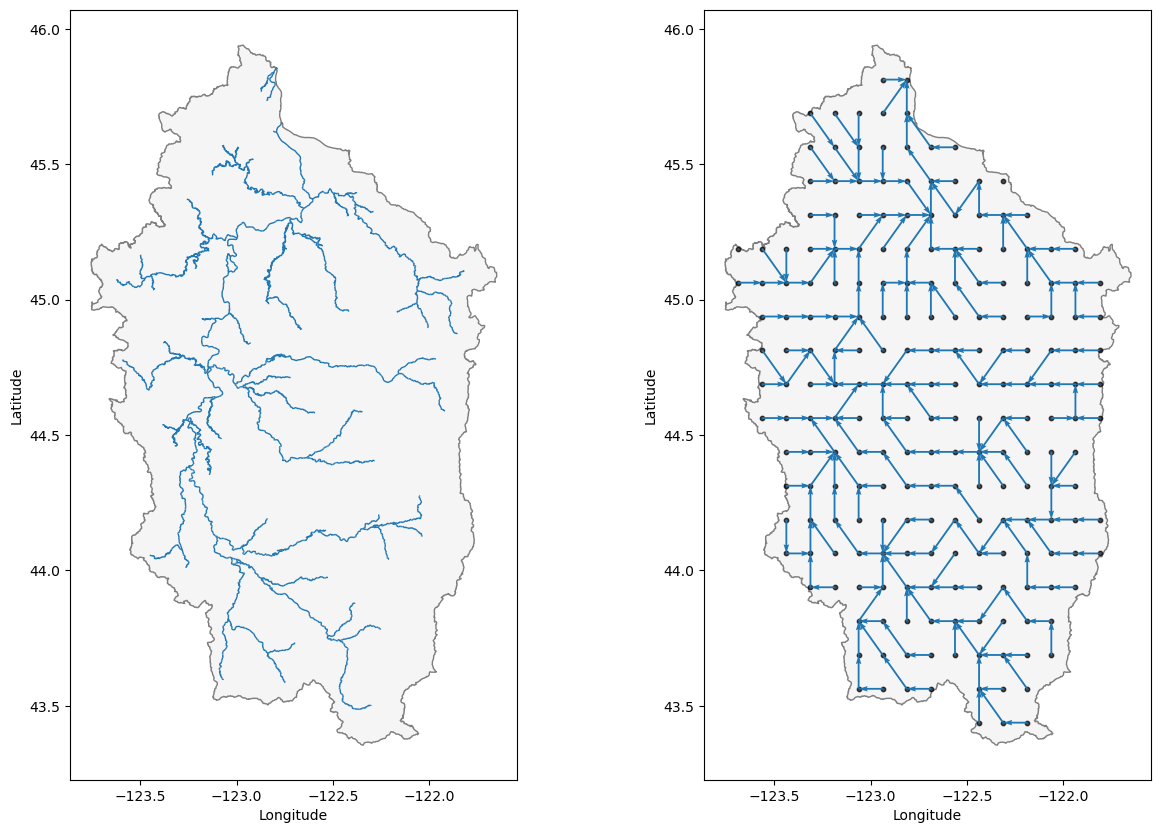

In [18]:
# ---- Visualize the graph on the map ---- #

res_metadata_df = pd.read_excel(f'{data_dir}/processed/reservoir_metadata.xlsx')

nodes_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
geometry = [Point(xy) for xy in zip(nodes_data['grid_lon'], nodes_data['grid_lat'])]
gdf_nodes = gpd.GeoDataFrame(nodes_data, geometry=geometry, crs='EPSG:4326')

lon_array_huc4 = np.unique(gdf_nodes['grid_lon'].values)
lat_array_huc4 = np.unique(gdf_nodes['grid_lat'].values)

# ------------------- Plot ------------------- #
# Variables to store components of arrows
x = []
y = []
dx = []
dy = []

default_lon = lon_array_huc4[0]
default_lat = lat_array_huc4[0]
for edge in G.edges():
    start_node = G.nodes[edge[0]]
    end_node = G.nodes[edge[1]]
    try:
        x_start, y_start = start_node['grid_lon'], start_node['grid_lat']
        x_end, y_end = end_node['grid_lon'], end_node['grid_lat']
    except KeyError:
        x_start, y_start = default_lon, default_lat
        x_end, y_end = default_lon, default_lat

    x.append(x_start)
    y.append(y_start)
    dx.append(x_end - x_start)
    dy.append(y_end - y_start)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 10))

# Plot basin and actual flow
gdf_huc4.plot(ax=ax[0], facecolor='whitesmoke', edgecolor='tab:gray', linewidth=1)

# plot flow line
# specify to which stream order
max_order = gdf_flow_huc4['StreamOrde'].max()
min_order_to_keep = 4
gdf_flow_huc4.loc[gdf_flow_huc4['StreamOrde']>=min_order_to_keep].plot(ax=ax[0], linewidth=1)

gdf_huc4.plot(ax=ax[1], facecolor='whitesmoke', edgecolor='tab:gray', linewidth=1)

# Plot nodes
gdf_nodes.plot(ax=ax[1], marker='o', color='black', alpha=0.7, markersize=10)

# Plot arrows
ax[1].quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='tab:blue')

# # Plot all reservoirs
# reservoir_id_list = list(set(df_reservoir_ts.columns[df_reservoir_ts.columns.str.contains('_release')].str.split('_').str[1].tolist()))
# reservoir_id_list = [int(reservoir_id) for reservoir_id in reservoir_id_list]

# for reservoir_id in reservoir_id_list:
#     reservoir_i, reservoir_j = np.where(grid['reservoir_id']==reservoir_id)
#     reservoir_i = reservoir_i[0]
#     reservoir_j = reservoir_j[0]
#     res_lat = res_metadata_df.loc[res_metadata_df['ID']==reservoir_id, 'lattitude'].values[0]
#     res_lon = res_metadata_df.loc[res_metadata_df['ID']==reservoir_id, 'longtitude'].values[0]

#     # plot reservoir
#     if reservoir_id == 367:
#         ax[0].scatter(res_lon, res_lat, marker='^', color='tab:red', s=100, label='Reservoir')
#     else:
#         ax[0].scatter(res_lon, res_lat, marker='^', color='tab:red', s=100)

# ax[0].legend()

# ax[0].set_title('Middle Snake River Basin')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# ax[1].set_title('Middle Snake River Basin - 1/4 degree grid')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

# save
plt.savefig('/Users/donghui/Box Sync/UIUC/Group Meeting/2024-SPRING/my_presentation/figures/demo_flow_map.jpg', dpi=300, bbox_inches='tight')

plt.show()

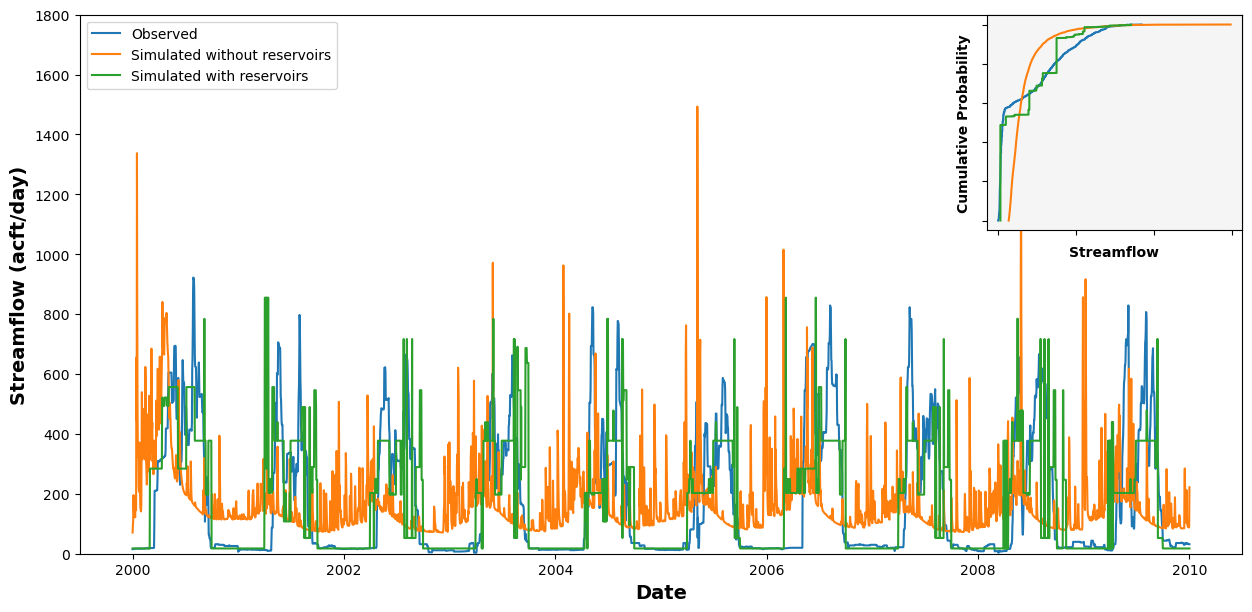

In [ ]:
# ---- Plot reservoir 367 time series & cdf ---- #

release_with_res_df = pd.read_csv(f'{data_dir}/{huc4}_res_release_with_res.csv')
release_with_res_df['date'] = pd.to_datetime(release_with_res_df['date'])
release_with_res_df.set_index('date', inplace=True)
release_without_res_df = pd.read_csv(f'{data_dir}/{huc4}_res_release_without_res.csv')
release_without_res_df['date'] = pd.to_datetime(release_without_res_df['date'])
release_without_res_df.set_index('date', inplace=True)

reservoir_id_list = [int(reservoir_id) for reservoir_id in reservoir_id_list]

# plot time series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(df_reservoir_ts[f'reservoir_367_observed_release'], label='Observed')
ax.plot(release_without_res_df['367'], label='Simulated without reservoirs')
ax.plot(release_with_res_df['367'], label='Simulated with reservoirs')

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Streamflow (acft/day)', fontsize=14, fontweight='bold')

ax.legend(loc='upper left', fontsize=10)

# set upper limit of y axis
ax.set_ylim(0, 1800)

# plot ecdf within the axix, on the top-right corner
# using the matplotlib.axes.Axes.inset_axes method
axins = ax.inset_axes([0.78, 0.6, 0.22, 0.4])
axins.plot(df_reservoir_ts[f'reservoir_367_observed_release'].sort_values(), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Observed')
axins.plot(np.sort(release_without_res_df['367']), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Simulated without reservoir operation')
axins.plot(np.sort(release_with_res_df['367']), np.arange(1, len(release_with_res_df)+1) / len(release_with_res_df), label='Simulated with reservoir operation')

axins.set_xlabel('Streamflow', fontweight='bold')
axins.set_ylabel('Cumulative Probability', fontweight='bold')

# remove axis
axins.set_xticklabels([])
axins.set_yticklabels([])

# add background color
axins.patch.set_facecolor('whitesmoke')

# save
plt.savefig('/Users/donghui/Desktop/time_series_367.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# plot ecdf
gid = 367
fig, ax = plt.subplots(figsize=(15, 1))
ax.plot(df_reservoir_ts[f'reservoir_{gid}_observed_release'].sort_values(), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Observed')
ax.plot(np.sort(release_without_res_df[f'{gid}']), np.arange(1, len(release_without_res_df)+1) / len(release_without_res_df), label='Simulated without reservoirs')
ax.plot(np.sort(release_with_res_df[f'{gid}']), np.arange(1, len(release_with_res_df)+1) / len(release_with_res_df), label='Simulated with reservoirs')

ax.set_title(f'Reservoir {gid}')
ax.legend()
plt.show()

# plot time series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df_reservoir_ts[f'reservoir_{gid}_observed_release'], label='Observed')
ax.plot(release_without_res_df[f'{gid}'], label='Simulated without reservoirs')
ax.plot(release_with_res_df[f'{gid}'], label='Simulated with reservoirs')

ax.set_title(f'Reservoir {gid}')
ax.legend()
plt.show()